<a href="https://colab.research.google.com/github/fachiny17/machine_learning/blob/main/tensorflow_course/07_milestone_project_1_food_vision_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision Big

## Check GPU

In [3]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [4]:
# Download helper functions script
!wget https://github.com/mrdbourke/tensorflow-deep-learning/raw/refs/heads/main/extras/helper_functions.py

--2025-11-24 20:33:39--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/refs/heads/main/extras/helper_functions.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py [following]
--2025-11-24 20:33:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-11-24 20

In [5]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

## Use TensorFlow Datasets to Download Data
If you want to get an overview of TensorFlow (TFDS), read the guide: https://www.tensorflow.org/datasets/overview

In [6]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
#datasets_list
print("food101" in datasets_list)

True


In [8]:
import tensorflow_datasets as tfds
print(tfds.__version__)


4.9.9


In [9]:
# Load in the data (takes 5-6 minutes)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple form (data, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.JEFEQN_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.JEFEQN_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

In [10]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [11]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [12]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [13]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 64,
  Class name (str form): miso_soup
  


In [15]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 43,  89, 125],
        [ 52,  96, 131],
        [ 85, 128, 162],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 42,  88, 124],
        [ 53,  97, 132],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       [[ 45,  89, 124],
        [ 52,  96, 131],
        [ 92, 135, 169],
        ...,
        [251, 254, 223],
        [250, 253, 222],
        [250, 253, 222]],

       ...,

       [[ 91,  99,  86],
        [ 89,  97,  84],
        [ 88,  94,  82],
        ...,
        [ 37,  44,  50],
        [ 34,  41,  47],
        [ 31,  38,  44]],

       [[ 91,  99,  86],
        [ 90,  98,  85],
        [ 88,  96,  83],
        ...,
        [ 38,  43,  47],
        [ 35,  40,  44],
        [ 33,  38,  42]],

       [[ 93, 101,  88],
        [ 93, 101,  88],
        [ 89,  97,  84],
        ...,
        [ 37,  42,  4

In [16]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

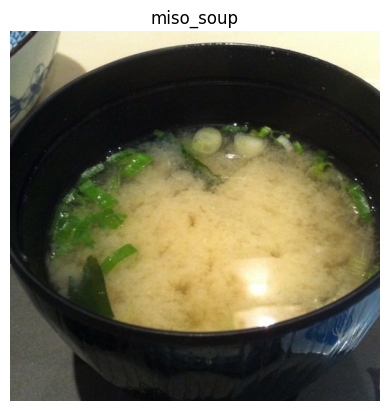

In [17]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

## Create preprocessing fuctions for our data

In [18]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image
  to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nShape: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 43  89 125]
  [ 52  96 131]
  [ 85 128 162]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]

 [[ 42  88 124]
  [ 53  97 132]
  [ 92 135 169]
  ...
  [251 254 223]
  [250 253 222]
  [250 253 222]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 48.969387  93.68367  129.04082 ]
  [124.78572  164.07144  195.28572 ]
  [125.37245  158.94388  183.5153  ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]

 [[ 65.28572  108.688774 143.09183 ]
  [129.93878  169.09184  200.17348 ]
  [ 79.61224  115.04081  140.88266 ]
  ...
  [251.78574  254.78574  223.78574 ]
  [251.       254.       223.      ]
  [250.       253.       222.      ]]]..., 
Shape: (224, 224, 3), 
Shape: <dtype: 'float32'>


## Batch and prepare datasets
We're now going to make our data input pipeline run really fast.

For more resources on this, I'd highly going through the following guide: https://www.tensorflow.org/guide/data_performance

In [20]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Hey, TensorFLow, map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.

 ## Create modelling callbacks

In [22]:
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.weights.h5" # Changed filepath to end with .weights.h5
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

## Setup mixed precision training

In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [24]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [25]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [26]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [27]:
from tensorflow.keras import layers

# Create a base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [29]:
# Check the dtype_policy attribute of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [30]:
# Check the dtype_policy attributes of layers in efficientnetb0
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
rescaling_1 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16"

In [31]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Fit the feature extraction model

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20251124-204814
Epoch 1/3
 148/2368 ━━━━━━━━━━━━━━━━━━━━ 6:59:37 11s/step - accuracy: 0.1517 - loss: 4.0354

In [ ]:
# Evaluate model (unsaved version) on whole test dataset
reults_feature_extract_model = model.evaluate(test_data)
reults_feature_extract_model

## Load and evaluate checkpoint weights

In [ ]:
# 1. Create a gunction to recreate the original model
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable=False

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # x = layers.Rescaling(1./255)(x) # but EfficientNetBX has built-in rescaling
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x=layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics = ["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

In [ ]:
created_model.summary()

In [ ]:
# Check the layers in base_model and see what dtype policy the're using
for layer in created_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

## Save the whole model to file

In [ ]:
# Saving the model locally(this is ephemeral and will delete when the session expires)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision.keras"
model.save(save_dir)

In [ ]:
# Load model previously saved above
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [ ]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

In [ ]:
# Are any of the layers in our model frozen?
for layer in loaded_saved_model.layers:
  layer.trainable=True
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [ ]:
# Check the layers in the base_model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype_policy)

## A Couple more callbacks

In [ ]:
# Setip EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/model.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
loaded_saved_model.compile(loss="sparse_categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                                     epochs=100, # fine-tune for a maximumof 100 epochs
                                                                     steps_per_epoch=len(train_data),
                                                                     validation_data=test_data,
                                                                     validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of the test data
                                                                     callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                                model_checkpoint, # save only the best model during training
                                                                                early_stopping, # stop model after X epochs of no improvements
                                                                                reduce_lr]) # reduce the learning rate after X epochs of no improvements

In [ ]:
loaded_saved_model.summary()

In [ ]:
# Save the model
loaded_saved_model.save("07_efficientnetb0_fine_tuned101_classes_mixed_precision.keras")